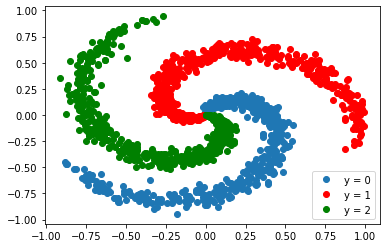

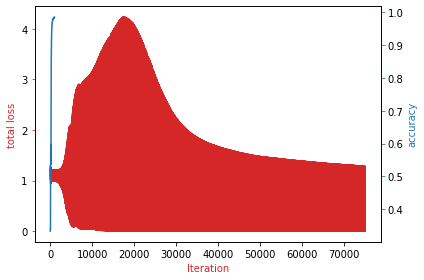

The accuracy at layer model [2,12,12,12,3]  0.9853333333333333


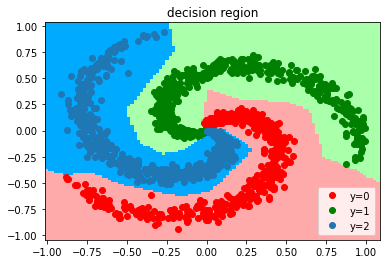

In [27]:

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader
from torch import optim

torch.manual_seed(1)


# Define the function to plot the diagram

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()


# Create Data Class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()



class NN(nn.Module):
  def __init__(self,layerlist):
    super(NN,self).__init__()
    self.thelist = nn.ModuleList()
    for in_,out_ in zip(layerlist, layerlist[1:]):
      self.thelist.append(nn.Linear(in_,out_))
  
  def forward(self,x):
    L = len(self.thelist)
    for l,thelinear in zip(range(L),self.thelist):
      if (l < L-1):
        x = torch.relu(thelinear(x))
      else:
        x = thelinear(x)
    return x



def accuracy(model,dataset):
  z = model(dataset.x)
  _,yhat = z.max(1)
  correct = (yhat == dataset.y).numpy().mean()
  return correct

def train(dataset,model,trainloader,criterion,optimiser,epochs):
  for epoch in range(epochs):
    for x,y in trainloader:
      yhat = model(x)
      loss = criterion(yhat,y)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      LOSS.append(loss)
    VAL.append(accuracy(model,dataset))
  
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.plot(LOSS, color = color)
  ax1.set_xlabel('Iteration', color = color)
  ax1.set_ylabel('total loss', color = color)
  ax1.tick_params(axis = 'y', color = color)
    
  ax2 = ax1.twinx()  
  color = 'tab:blue'
  ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
  ax2.plot(VAL, color = color)
  ax2.tick_params(axis = 'y', color = color)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
  plt.show()




data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)
train_loader = DataLoader(dataset=data_set,batch_size=20)
epochs = 1000
criterion= nn.CrossEntropyLoss()

# The accuracy at 1 layer model [2,30,3]   0.9606666666666667
# The accuracy at 2 layer model [2,20,10,3] (BIGGER FIRST) 0.98
# The accuracy at 2 layer model [2,10,20,3](BIGGER LAST)  0.9726666666666667
# The accuracy at 3 layer model [2,10,10,10,3] 0.982
# The accuracy at layer model [2,6,6,6,6,6,3]  0.982


# The accuracy at layer model [2,36,3]  0.9546666666666667
# The accuracy at layer model [2,12,12,12,3]  0.9713333333333334

LOSS=[]
VAL=[]
#1
layers = [2,10,10,10,3]
model = NN(layers)
optimiser = optim.SGD(model.parameters(),lr=0.01)
train(data_set,model,train_loader,criterion,optimiser,epochs)
plot_decision_regions_3class(model, data_set)
print("The accuracy at layer model [2,12,12,12,3] ", accuracy(model,data_set))

